In [1]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding import angle_encoding
from haar_noising import apply_haar_scrambling

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

importing Jupyter notebook from angle_encoding.ipynb
importing Jupyter notebook from haar_noising.ipynb
torch.Size([1000, 8, 8, 4])
torch.Size([1000, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_15472\107961985.py:18: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:300.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, intermediate_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, intermediate_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(intermediate_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
intermediate_dim = 16

model = DiffusionModel(input_dim, hidden_dim, output_dim, intermediate_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/60], Loss: 0.9956, FID: 239.5822
Epoch [2/60], Loss: 0.9448, FID: 220.0427
Epoch [3/60], Loss: 0.8695, FID: 192.4616
Epoch [4/60], Loss: 0.7636, FID: 158.6685
Epoch [5/60], Loss: 0.6347, FID: 127.4710
Epoch [6/60], Loss: 0.5195, FID: 109.5826
Epoch [7/60], Loss: 0.4502, FID: 94.3724
Epoch [8/60], Loss: 0.3916, FID: 73.5457
Epoch [9/60], Loss: 0.3133, FID: 54.3532
Epoch [10/60], Loss: 0.2367, FID: 42.2498
Epoch [11/60], Loss: 0.1886, FID: 35.9070
Epoch [12/60], Loss: 0.1608, FID: 31.6512
Epoch [13/60], Loss: 0.1421, FID: 26.1804
Epoch [14/60], Loss: 0.1187, FID: 21.8257
Epoch [15/60], Loss: 0.1081, FID: 19.6494
Epoch [16/60], Loss: 0.0980, FID: 18.9739
Epoch [17/60], Loss: 0.0988, FID: 18.5215
Epoch [18/60], Loss: 0.0937, FID: 16.4344
Epoch [19/60], Loss: 0.0875, FID: 14.3386
Epoch [20/60], Loss: 0.0781, FID: 14.5171
Epoch [21/60], Loss: 0.0800, FID: 14.7212
Epoch [22/60], Loss: 0.0783, FID: 13.5261
Epoch [23/60], Loss: 0.0756, FID: 13.0515
Epoch [24/60], Loss: 0.0697, FID: 12.

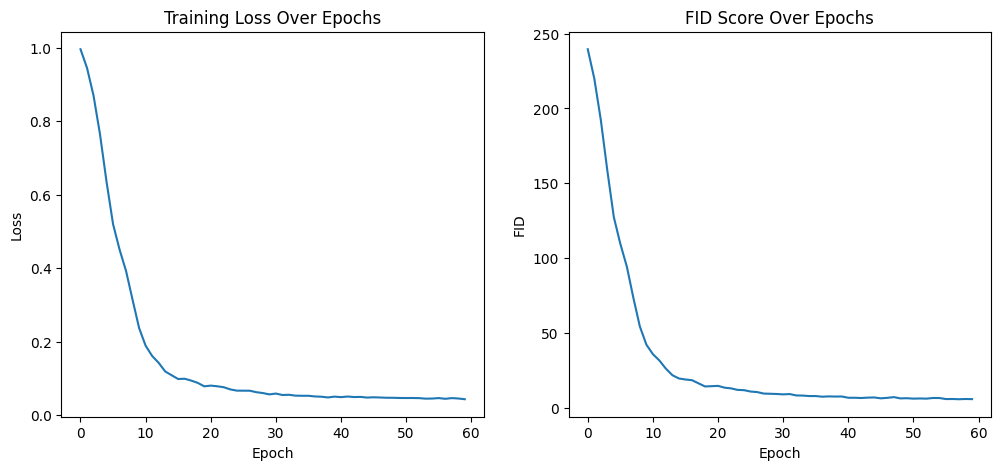

In [3]:
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_decoded_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid


num_epochs = 60
loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    denoised_states = model(scrambled_states.view(num_samples, -1))
    denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
    decoded_data = decode(denoised_states)
    decoded_data = flip(decoded_data)

    mu1, sigma1 = calculate_statistics(data_X)
    mu2, sigma2 = calculate_statistics(decoded_data)
    fid = calculate_fid(mu1, sigma1, mu2, sigma2)
    fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(fid_scores)
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')

plt.show()


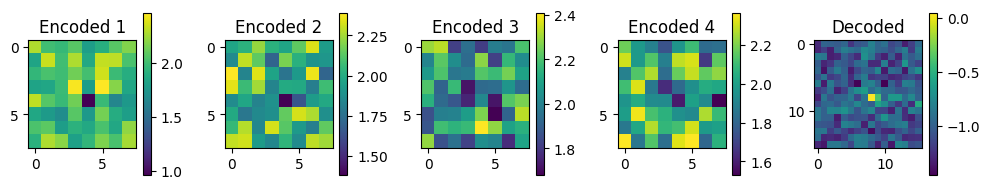

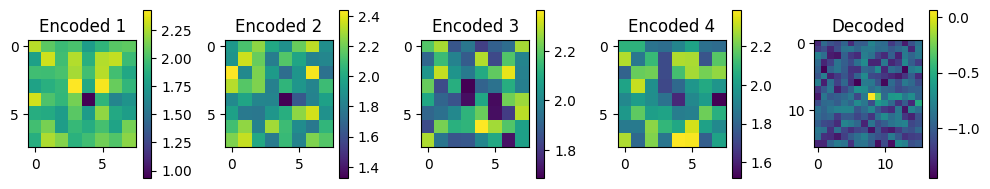

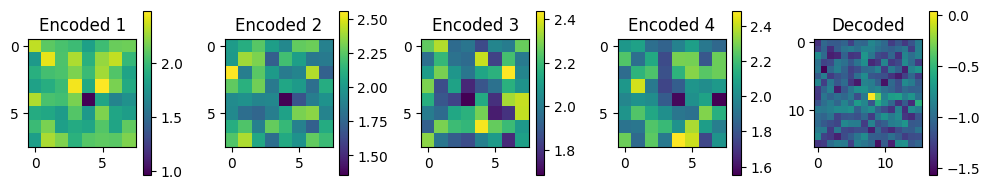

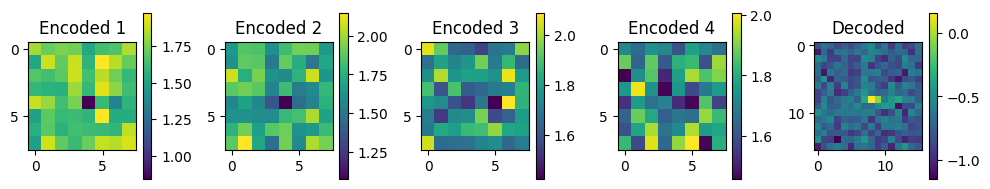

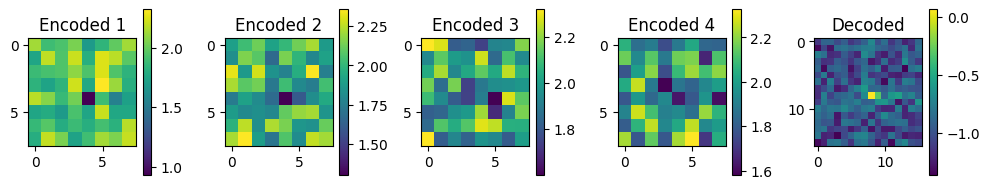

In [14]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)